In [14]:
import pandas as pd
import yfinance as yf
import numpy as np
import math

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras_tuner as kt
from keras.models import Sequential
from tensorflow.keras.layers import Dropout, Activation, Dense, LSTM
from keras_tuner.tuners import Hyperband


In [15]:
df_raw = yf.download('^GSPC', start='2000-01-01')
df_raw = df_raw.filter(['Close'])

tt_split = 0.2

dataset = df_raw.values
dataset_len = math.ceil(len(dataset) * (1-tt_split))

[*********************100%***********************]  1 of 1 completed


In [16]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [17]:
dataset.shape

(5832, 1)

In [18]:
def df_to_x_y(df,window_size):
    df_as_np = df #.to_numpy()
    x = []
    y = []
    for i in range(len(df)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        x.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
        
    x = np.array(x)
    x = np.reshape(x, (x.shape[0], x.shape[1], x.shape[2]))
    
    return x, np.array(y)

In [19]:
x, y = df_to_x_y(scaled_data,25)

In [20]:
x.shape

(5807, 25, 1)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=tt_split, shuffle=False)

In [22]:
x_test.shape

(1162, 25, 1)

In [68]:
def model_builder(hp):
    model = tf.keras.Sequential()
    
    model.add(LSTM(units=hp.Int('units', min_value=32,max_value=192,step=8), return_sequences=False, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.2))
    
    # model.add(LSTM(units=hp.Int('units1', min_value=32, max_value=512, step=32), return_sequences=False))
    # model.add(Dropout(0.4))
    
    # model.add(tf.keras.layers.Dense(hp.Int('units2', min_value=32, max_value=512, step=32), activation='relu'))
    # model.add(Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(units=1, activation='relu'))
    
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    
    return model

In [69]:
hpTuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=5,
    #factor=3,
    directory='RandomSearch',
    project_name='GSPC-7'
    #overwrite = True
)

early_stop = [tf.keras.callbacks.EarlyStopping('val_loss', patience=2)]; # early stop, so the search doesn't go on forever, whilst making little to no progress

In [70]:
hpTuner.search(x_train, y_train, epochs=6, validation_split=0.2,callbacks=early_stop)

Trial 5 Complete [00h 00m 31s]
val_loss: 0.00011268608795944601

Best val_loss So Far: 7.5245596235618e-05
Total elapsed time: 00h 05m 25s
INFO:tensorflow:Oracle triggered exit


In [71]:
bestHpsHB = hpTuner.get_best_hyperparameters()[0]
best_hps=hpTuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'units': 160, 'units1': 224, 'learning_rate': 0.001}

In [72]:
hpModel= hpTuner.get_best_models()[0]

In [73]:
# the optimal model to be using for the data set
hpModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 160)           103680    
                                                                 
 dropout (Dropout)           (None, 25, 160)           0         
                                                                 
 lstm_1 (LSTM)               (None, 224)               344960    
                                                                 
 dense (Dense)               (None, 1)                 225       
                                                                 
Total params: 448,865
Trainable params: 448,865
Non-trainable params: 0
_________________________________________________________________


In [74]:
historyHB = hpModel.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=early_stop)

Epoch 1/5
117/117 [==============================] - 12s 77ms/step - loss: 7.0547e-05 - val_loss: 9.0754e-05
Epoch 2/5
117/117 [==============================] - 8s 69ms/step - loss: 7.1168e-05 - val_loss: 2.2533e-04
Epoch 3/5
117/117 [==============================] - 8s 71ms/step - loss: 6.6662e-05 - val_loss: 1.0343e-04


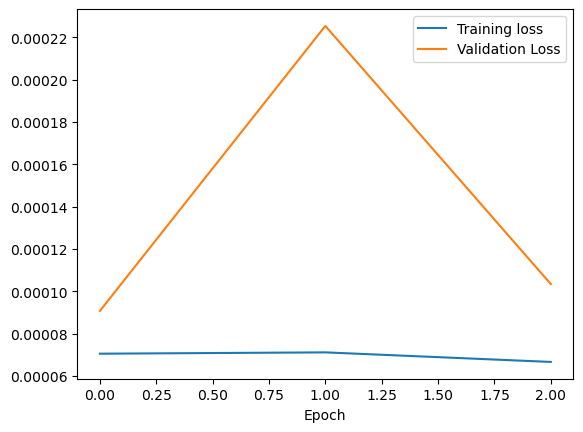

In [75]:
plt.plot(historyHB.history['loss'],label='Training loss')
plt.plot(historyHB.history['val_loss'],label='Validation Loss')
plt.xlabel('Epoch')
plt.legend()

#plt.tight_layout()
#plt.savefig("Keras - Validation and Training Loss")

In [91]:
predictionsLSTM = hpModel.predict(x_test)
predictionsLSTM = scaler.inverse_transform(predictionsLSTM)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

37/37 [==============================] - 1s 20ms/step


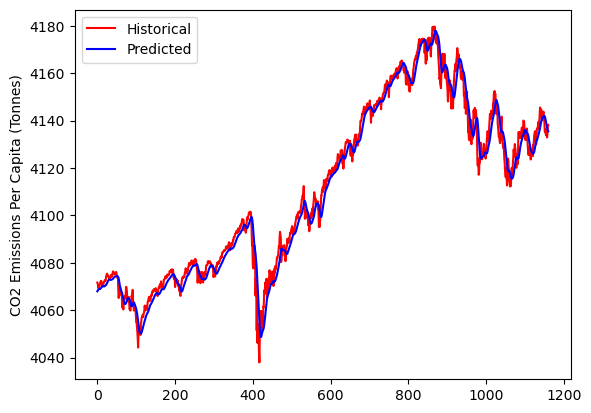

In [92]:
plt.plot(y_test_scaled, color='r')
plt.plot(predictionsLSTM, color='b')

plt.ylabel("CO2 Emissions Per Capita (Tonnes)")

legend = ['Historical', 'Predicted']
plt.legend(legend)

#plt.tight_layout()
#plt.savefig("Keras - Predicted and Test")

C:\Users\jack_\AppData\Local\Temp\ipykernel_23020\1045969958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictionsLSTM


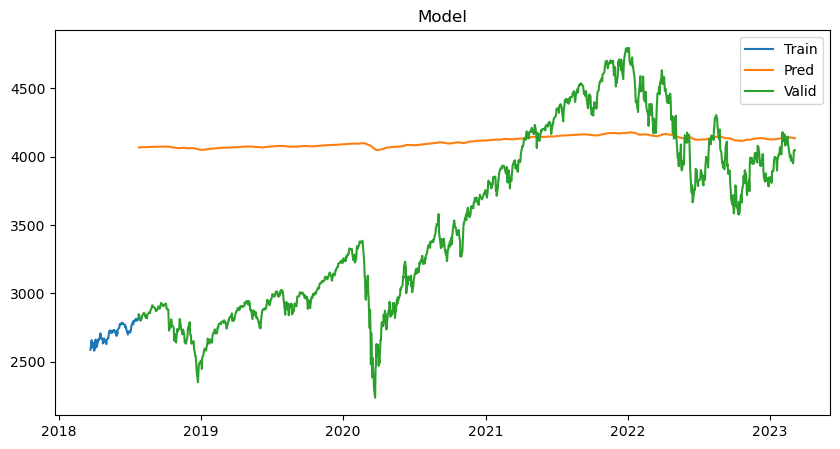

In [90]:
# plot prediciton data
train = df_raw[dataset_len-80:dataset_len+10]
valid = df_raw[(len(df_raw) - len(predictionsLSTM)):]
valid['predictions'] = predictionsLSTM

# visualise the model
plt.figure(figsize=(10,5))
plt.title('Model')
plt.plot(train)
plt.plot(valid[['predictions', 'Close']])
plt.legend(['Train', 'Pred', 'Valid'])

### Forecast for tomorrow

In [80]:
last_60 = df_raw[-25:].values
last_60 = scaler.fit_transform(last_60)
new_x_test = []
new_x_test.append(last_60)
new_x_test = np.array(new_x_test)
new_x_test = np.reshape(new_x_test, (new_x_test.shape[0], new_x_test.shape[1], 1))
price_pred = hpModel.predict(new_x_test)
price_pred = scaler.inverse_transform(price_pred)
print(f'\nPredicted close for next trading day: {round(float(price_pred[0]),2)} (from: {round(valid.predictions[-1],2)})')
print(f'Most recent close price: {round(df_raw.Close[-1],2)}')

1/1 [==============================] - 0s 30ms/step

Predicted close for next trading day: 4005.01 (from: 4135.490234375)
Most recent close price: 4047.12


---

### Future Forecast (Multiple Steps)

In [81]:
n_future = 50
y_future = []

In [82]:
x_pred = x_test[-1:, :, :]  # last observed input sequence
y_pred = y_test[-1]         # last observed target value

In [83]:
y_test.shape

(1161, 1)

In [84]:
for i in range(n_future):

    # feed the last forecast back to the model as an input
    x_pred = np.append(x_pred[:, 1:, :], y_pred.reshape(1, 1, 1), axis=1)

    # generate the next forecast
    y_pred = hpModel.predict(x_pred)

    # save the forecast
    y_future.append(y_pred.flatten()[0])

1/1 [==============================] - 0s 26ms/step


In [85]:
y_future = np.array(y_future).reshape(-1, 1)
y_future = scaler.inverse_transform(y_future)

In [86]:
df_past = df_raw[['Close']].reset_index()
df_past.rename(columns={'index': 'Date'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan

df_future = pd.DataFrame(columns=['Date', 'Close', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_future)
df_future['Forecast'] = y_future.flatten()
df_future['Close'] = np.nan

results = df_past.append(df_future).set_index('Date')

C:\Users\jack_\AppData\Local\Temp\ipykernel_23020\3943890167.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('Date')


<Axes: xlabel='Date'>

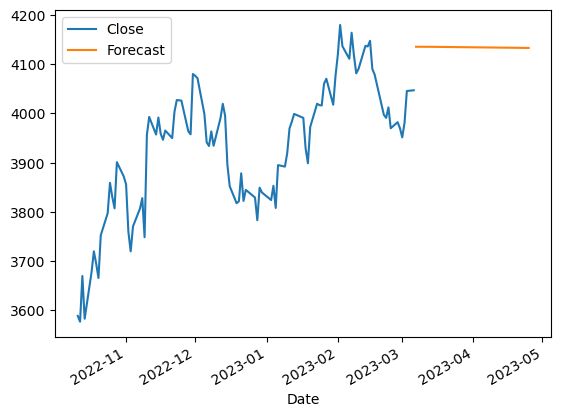

In [87]:
results[-150:].plot()

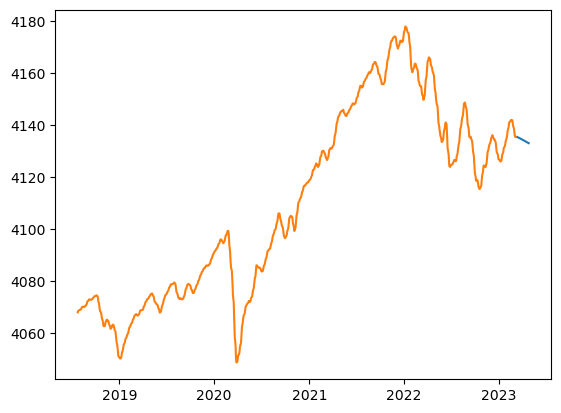

In [88]:
plt.plot(results.Forecast)
plt.plot(valid.predictions)

In [89]:
results.Forecast[-n_future] 

4135.523